# Running the QRF Model 


In [1]:
from quantum_random_forest import QuantumRandomForest, set_multiprocessing
from split_function import SplitCriterion
from data_construction import data_preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics, datasets

print("done")

C:\Users\dee2\anaconda3\envs\qrf\lib\site-packages\qiskit\circuit\equivalence.py:18: DeprecationWarning: The retworkx package is deprecated and has been renamed to rustworkx. Rustworkx is a drop-in replacement and can be used by replacing `import retworkx` with import `rustworkx`. 
  import retworkx as rx


done


## Load dataset

Here you can load your own dataset. The preprocessing can be left untouched. However, it is important to note that certain embeddings require data of certain dimension. PCA reduction to the required dimension can be achieved by changing the X_dim variable. 

In [3]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import pickle
from os import path
print('done')

done


In [4]:
bin_data = pd.read_csv('final_dataset_IDS.csv')
bin_data.drop(bin_data.columns[0], axis=1, inplace=True)
bin_data

,state_INT,state_CON,sttl,ct_state_ttl,label
0,1,0,0.995536,0.333333,0
1,0,0,0.995536,0.166667,0
2,0,0,0.138393,0.166667,0
3,0,0,0.995536,1.000000,0
4,1,0,0.995536,0.333333,0
...,...,...,...,...,...
995,0,1,0.000000,0.000000,1
996,0,1,0.000000,0.000000,1
997,0,0,0.000000,0.000000,1
998,0,1,0.000000,0.000000,1


In [5]:
X = bin_data.drop(columns=['label'],axis=1)
y = bin_data['label']
print('done')

done


### Data pre-processing

In [7]:
training_set, testing_set = data_preprocessing(X, y, 
                                               train_prop=0.75,        # Proportion of dataset allocated for training
                                               X_dim=4)                # Determine the required dimension of the dataset. None for default.
print("done")

New datapoint dimension: 4
done


## Model parameters 

In [8]:
n_qubits = 4                                        # Number of qubits for the embedding
dt_type = 'qke'                                      # Do not touch
ensemble_var = None                                  # Do not touch
branch_var = ['eff_anz_pqc_arch', 
              'iqp_anz_pqc_arch', 
              'eff_anz_pqc_arch']                    # Type of Anzatz, or as a list for different down the tree - as given 
num_trees = 2                                        # Number of trees in ensemble 
split_num = 2                                        # Do not touch
pqc_sample_num = 2024                                # Number of circuit samples per kernel estimation
num_classes = 2                            # Number of classes in dataset
max_depth = 4                                        # Maximum depth of the tree
num_params_split = n_qubits*(n_qubits +1)            # Number of parameters in the embedding (different for different anzatz), list for different down the tree [2 * n_qubits ** 2 , n_qubits*(n_qubits +1), 2 * n_qubits ** 2]
num_rand_gen = 1                                     # Do not touch
num_rand_meas_q = n_qubits                           # Do not touch 
svm_num_train = 5                                    # L, Number of Landmarks
svm_c = 10                                           # C term in SVM optimisation, or list down the tree [100, 50, 20]
min_samples_split = svm_num_train                    # Minimum number of samples
embedding_type = ['as_params_all', 
                  'as_params_iqp', 
                  'as_params_all']                   # Type of embedding, or as a list - as given
criterion = SplitCriterion.init_info_gain('clas')    # Do not touch
device = 'cirq'                                      # Choose a device. Also possible to run on IBM
print("done")

done


## Set up model

In [9]:
qrf = QuantumRandomForest(n_qubits, 'clas', num_trees, criterion, max_depth=max_depth, 
                          min_samples_split=min_samples_split, tree_split_num=split_num, num_rand_meas_q=num_rand_meas_q,
                          ensemble_var=ensemble_var, dt_type=dt_type, num_classes=num_classes, ensemble_vote_type='ave',
                          num_params_split=num_params_split, num_rand_gen=num_rand_gen, pqc_sample_num=pqc_sample_num,
                          embed=embedding_type, branch_var=branch_var, svm_num_train=svm_num_train, svm_c=svm_c, 
                          nystrom_approx=True, device=device)
print("done")

done


## Train

In [24]:
cores = 3
set_multiprocessing(True, cores) # Set to False if you don't want parallel computation

import time
start = time.time()
qrf.train(training_set, 
          partition_sample_size=180)  # Partition size is the number of instances given to each tree. Set to None to use all the data for all trees

elapsed = time.time() - start
trainingtime = elapsed
print(f"Training time: {elapsed} seconds")

print("done")

Training time: 20.519191026687622 seconds
done


## Test

In [ ]:
import time
start = time.time()

acc, preds_qrf = qrf.test(testing_set, 
                          ret_pred=True, 
                          parallel=False,            # Set to False if you don't want parallel computation. Needs to be False for calc_tree_corr to be True.
                          calc_tree_corr=True)       # True is required to later look at correlations between trees

Telapsed = time.time() - start
testingtime= Telapsed
print(f"Testing time: {Telapsed} seconds")
print("done")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4971.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2499.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5003.94it/s]

100%|███████████████████████████

Testing time: 7.976003885269165 seconds
done


In [20]:
# Classification report
print(f"Classification report for QRF:\n"
      f"{metrics.classification_report(testing_set.y, preds_qrf)}\n")
    

Classification report for QRF:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       176
           1       1.00      0.92      0.96        74

    accuracy                           0.98       250
   macro avg       0.98      0.96      0.97       250
weighted avg       0.98      0.98      0.98       250




## Further analysis of model

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=rf_bin.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_bin.classes_)
print('Quantum RandomForestClassifier confusion matrix')
disp.plot()
plt.show()

In [14]:
# Print out tree
qrf.print_trees()


 ---------------------------------------- 

`- () - 180 instances
   |- () - 152 instances
   |  |- () - 123 instances
   |  |  |- ({0: 0.96, 1: 0.04}) - 123 instances
   |  |  `- ({0: 0.96, 1: 0.04}) - 0 instances
   |  `- ({0: 0.0, 1: 1.0}) - 29 instances
   `- () - 28 instances
      |- () - 14 instances
      |  |- ({0: 0.86, 1: 0.14}) - 14 instances
      |  `- ({0: 0.86, 1: 0.14}) - 0 instances
      `- ({0: 0.0, 1: 1.0}) - 14 instances

 ---------------------------------------- 

`- () - 180 instances
   |- () - 109 instances
   |  |- () - 93 instances
   |  |  |- ({0: 0.98, 1: 0.02}) - 93 instances
   |  |  `- ({0: 0.98, 1: 0.02}) - 0 instances
   |  `- ({0: 0.0, 1: 1.0}) - 16 instances
   `- () - 71 instances
      |- ({0: 0.0, 1: 1.0}) - 35 instances
      `- () - 36 instances
         |- ({0: 0.89, 1: 0.11}) - 36 instances
         `- ({0: 0.89, 1: 0.11}) - 0 instances


Class 0


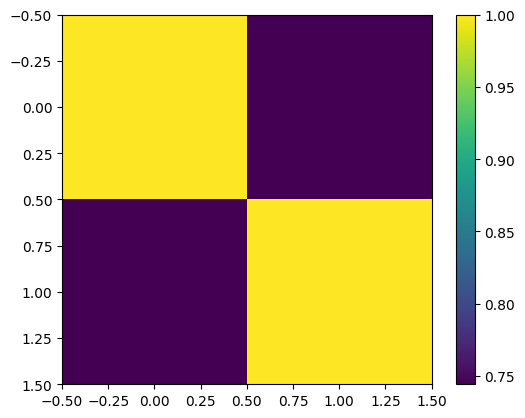

Class 1


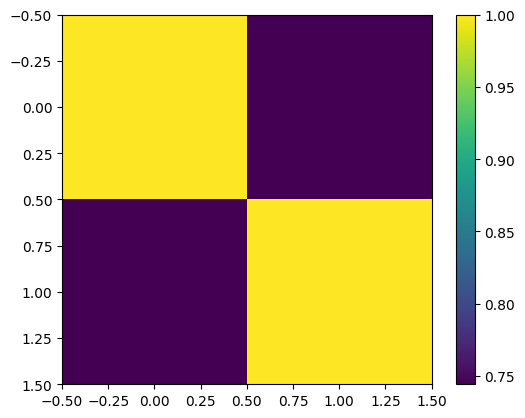

In [15]:
corr_dict = qrf.compute_tree_correlation()
for k,v in corr_dict.items():
    print("Class", k)
    plt.imshow(v)
    plt.colorbar()
    plt.show()